In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import log_loss, classification_report, accuracy_score,mean_squared_error
from sklearn.model_selection import GridSearchCV

Splitting in train-test-val

In [2]:
train = pd.read_csv("Data/fashion-mnist_train.csv")[:8000]
test = pd.read_csv("Data/fashion-mnist_test.csv")[:2000]
val = pd.read_csv("Data/fashion-mnist_test.csv")[2000:3000]

train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
y_train = train['label']
X_train = train.drop(columns=['label'])

y_test = test['label']
X_test = test.drop(columns=['label'])

y_val = val['label']
X_val = val.drop(columns=['label'])

Normalizing the data

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(data=X_train_scaled, columns=X_train.columns)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(data=X_test_scaled, columns=X_test.columns)

X_val_scaled = scaler.transform(X_val)
X_val_scaled = pd.DataFrame(data=X_val_scaled, columns=X_val.columns)

X_train_scaled.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.022936,0.0,0.0,...,0.000000,0.0,0.0,0.11811,0.174089,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.006098,0.009217,0.0,0.0,0.000000,0.0,0.0,...,0.012097,0.0,0.0,0.00000,0.000000,0.003922,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0


# A

First 10 images in the test set

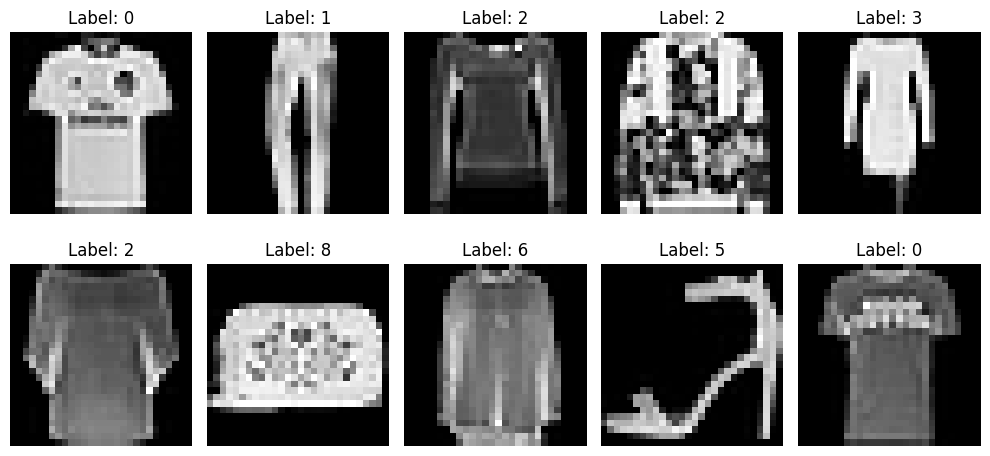

In [5]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test.iloc[i].values.reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_test.iloc[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# B

Training on all of the activation functions

In [6]:
logs = {}

max_iter = 100
activations = ['logistic', 'tanh', 'relu', 'identity']

for activation in activations:
    mlp = MLPClassifier(
        hidden_layer_sizes=[128, 64, 32],
        max_iter=1,
        batch_size=128,
        solver='adam',
        learning_rate_init=2e-5,
        activation=activation,
        random_state=42,
        verbose=False
    )
    
    train_losses = []
    val_losses = []
    best_val_accuracy = 0
    
    for epoch in range(1, max_iter + 1):
        mlp.partial_fit(X_train_scaled, y_train, classes=np.unique(y_train))
        
        y_train_pred = mlp.predict_proba(X_train_scaled)
        train_loss = log_loss(y_train, y_train_pred)
        train_losses.append(train_loss)
        
        y_val_pred = mlp.predict_proba(X_val_scaled)
        val_loss = log_loss(y_val, y_val_pred)
        val_losses.append(val_loss)
        
        y_val_pred_labels = np.argmax(y_val_pred, axis=1)
        val_accuracy = accuracy_score(y_val, y_val_pred_labels)
        
        y_test_pred_labels = np.argmax(mlp.predict_proba(X_test_scaled), axis=1)
        test_set = classification_report(y_test, y_test_pred_labels, zero_division=0)
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
    
    logs[activation] = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'best_val_accuracy': best_val_accuracy,
        'test_set': test_set
    }


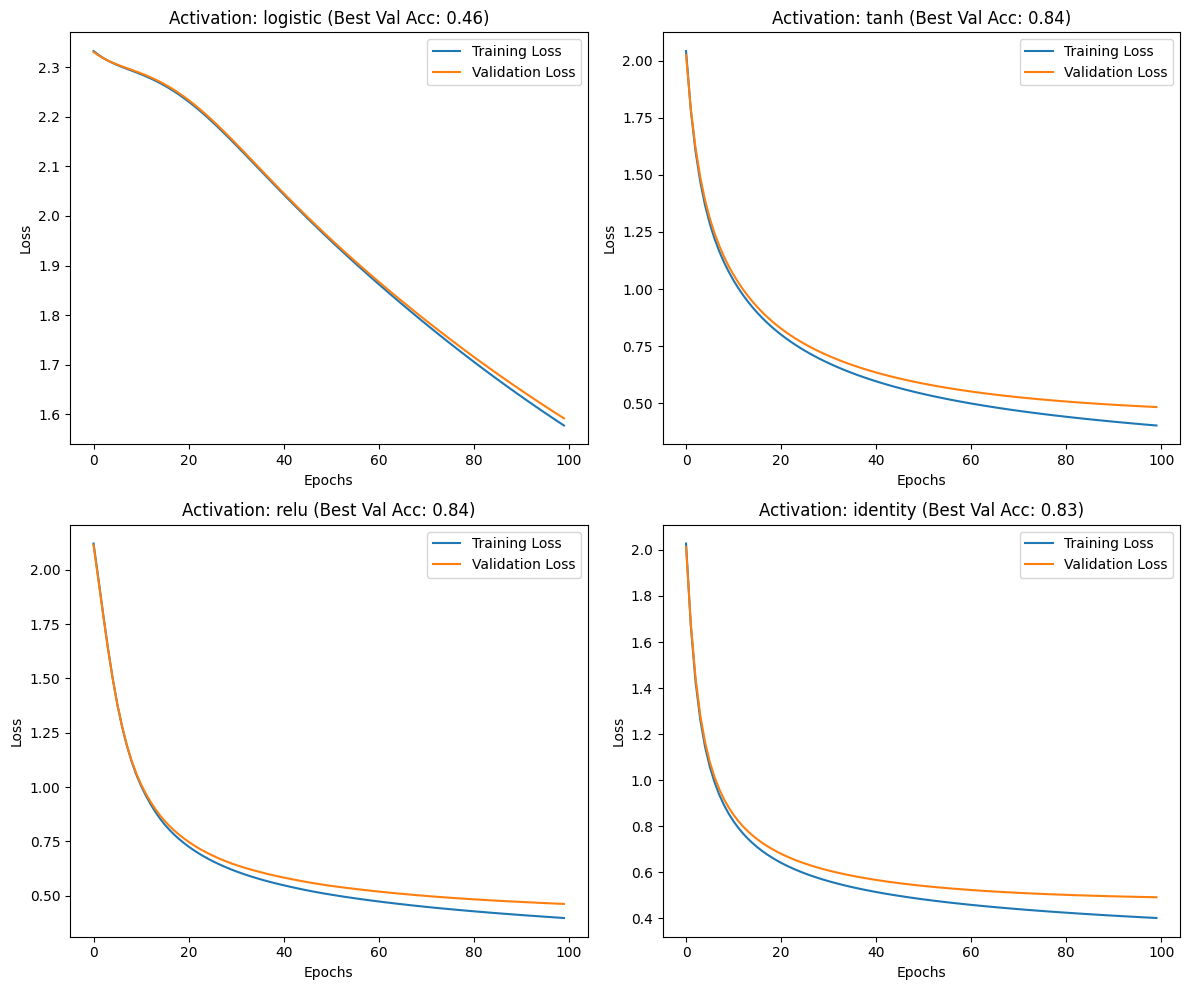

Best val loss for activation 'logistic': 1.5920
Metrics:               precision    recall  f1-score   support

           0       0.00      0.00      0.00       195
           1       0.39      0.96      0.55       189
           2       0.34      0.70      0.45       205
           3       0.22      0.16      0.18       200
           4       0.32      0.07      0.12       199
           5       0.00      0.00      0.00       202
           6       0.28      0.18      0.22       213
           7       0.52      0.96      0.67       204
           8       0.96      0.78      0.86       188
           9       0.59      0.71      0.65       205

    accuracy                           0.45      2000
   macro avg       0.36      0.45      0.37      2000
weighted avg       0.36      0.45      0.37      2000

Best val loss for activation 'tanh': 0.4834
Metrics:               precision    recall  f1-score   support

           0       0.79      0.85      0.82       195
           1       0.9

In [7]:
plt.figure(figsize=(12, 10))
for i, activation in enumerate(activations, 1):
    plt.subplot(2, 2, i)
    plt.plot(logs[activation]['train_loss'], label='Training Loss')
    plt.plot(logs[activation]['val_loss'], label='Validation Loss')
    plt.title(f'Activation: {activation} (Best Val Acc: {logs[activation]["best_val_accuracy"]:.2f})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()

for activation in activations:
    best_val_loss = min(logs[activation]['val_loss'])
    print(f"Best val loss for activation '{activation}': {best_val_loss:.4f}")
    print(f"Metrics:", logs[activation]['test_set'])
    

# C

In [69]:
param_grid = {
    "solver" : ["sgd","adam"],
    "batch_size": [32,64,128],
    "learning_rate_init" : [2e-4,2e-5,2e-6]
}

model = MLPClassifier(
    hidden_layer_sizes=[128,64,32],
    max_iter=100,
    random_state=42,
    activation="relu",
)

grid = GridSearchCV(model,param_grid,cv=3,scoring="accuracy",n_jobs=-1)
grid.fit(X_train_scaled,y_train)


c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=MLPClassifier(hidden_layer_sizes=[128, 64, 32],
                                     max_iter=100, random_state=42),
             n_jobs=-1,
             param_grid={'batch_size': [32, 64, 128],
                         'learning_rate_init': [0.0002, 2e-05, 2e-06],
                         'solver': ['sgd', 'adam']},
             scoring='accuracy')

Best params

In [70]:
print(grid.best_params_)
grid_pred = grid.predict(X_test_scaled)

print(classification_report(y_test, grid_pred))

{'batch_size': 64, 'learning_rate_init': 0.0002, 'solver': 'adam'}
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       195
           1       0.98      0.96      0.97       189
           2       0.72      0.73      0.72       205
           3       0.89      0.89      0.89       200
           4       0.79      0.76      0.77       199
           5       0.95      0.88      0.91       202
           6       0.66      0.65      0.66       213
           7       0.87      0.92      0.90       204
           8       0.94      0.93      0.93       188
           9       0.90      0.93      0.91       205

    accuracy                           0.84      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.84      0.84      2000



Checking the performance on the best params

In [9]:
grid_logs = {}
train_losses = []
val_losses = []
best_val_accuracy = 0

max_iter = 100  
check_model = MLPClassifier(
    hidden_layer_sizes=[128, 64, 32],
    max_iter=1,
    batch_size=64,
    learning_rate_init=0.0002,
    solver="adam",
    activation="relu",
    random_state=42
)

for epoch in range(1, max_iter + 1):
    check_model.partial_fit(X_train_scaled, y_train, classes=np.unique(y_train))
    
    y_train_pred = check_model.predict_proba(X_train_scaled)
    train_loss = log_loss(y_train, y_train_pred)
    train_losses.append(train_loss)

    y_val_pred = check_model.predict_proba(X_val_scaled)
    val_loss = log_loss(y_val, y_val_pred)
    val_losses.append(val_loss)

    y_val_pred_labels = np.argmax(y_val_pred, axis=1)
    val_accuracy = accuracy_score(y_val, y_val_pred_labels)

    y_test_pred_labels = np.argmax(check_model.predict_proba(X_test_scaled), axis=1)
    test_set = classification_report(y_test, y_test_pred_labels, zero_division=0)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy

# Store the logs
grid_logs['relu'] = {
    'train_loss': train_losses,
    'val_loss': val_losses,
    'best_val_accuracy': best_val_accuracy,
    'test_set': test_set
}



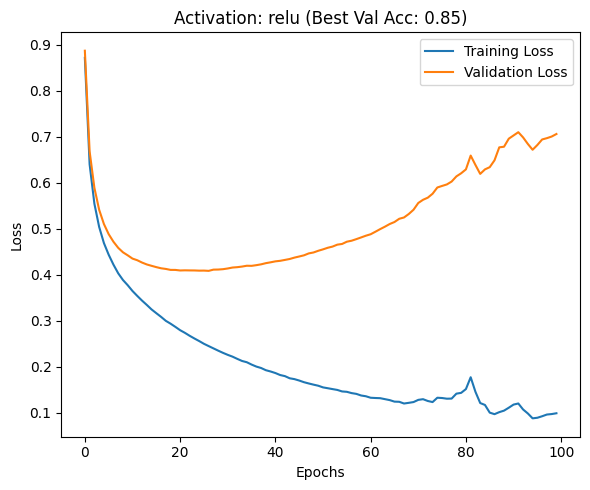

Best val loss for activation 'relu': 0.4080
Metrics:               precision    recall  f1-score   support

           0       0.79      0.81      0.80       195
           1       0.97      0.96      0.97       189
           2       0.72      0.74      0.73       205
           3       0.85      0.93      0.89       200
           4       0.71      0.82      0.76       199
           5       0.94      0.89      0.91       202
           6       0.76      0.56      0.64       213
           7       0.85      0.93      0.89       204
           8       0.95      0.94      0.95       188
           9       0.93      0.90      0.92       205

    accuracy                           0.84      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.84      0.84      2000



In [10]:
plt.figure(figsize=(6, 5))
plt.plot(grid_logs['relu']['train_loss'], label='Training Loss')
plt.plot(grid_logs['relu']['val_loss'], label='Validation Loss')
plt.title(f"Activation: relu (Best Val Acc: {grid_logs['relu']['best_val_accuracy']:.2f})")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

best_val_loss = min(grid_logs['relu']['val_loss'])
print(f"Best val loss for activation 'relu': {best_val_loss:.4f}")
print("Metrics:", grid_logs['relu']['test_set'])

# D

In [6]:
logs = {'relu': {'train_loss': [], 'val_loss': []},
        'identity': {'train_loss': [], 'val_loss': []}}

mlp_r_relu = MLPRegressor(
    hidden_layer_sizes=[128,64,32,64,128],
    max_iter=1, 
    solver="adam",
    activation="relu",
    random_state=42
)

mlp_r_identity = MLPRegressor(
    hidden_layer_sizes=[128,64,32,64,128],
    max_iter=1,
    solver="adam",
    activation="identity",
    random_state=42
)

In [7]:
for epoch in range(1, 101):
    # ReLU
    mlp_r_relu.partial_fit(X_train_scaled, X_train_scaled)
    train_loss_relu = mean_squared_error(X_train_scaled, mlp_r_relu.predict(X_train_scaled))
    val_loss_relu = mean_squared_error(X_val_scaled, mlp_r_relu.predict(X_val_scaled))
    logs['relu']['train_loss'].append(train_loss_relu)
    logs['relu']['val_loss'].append(val_loss_relu)

    # Identity
    mlp_r_identity.partial_fit(X_train_scaled, X_train_scaled)
    train_loss_identity = mean_squared_error(X_train_scaled, mlp_r_identity.predict(X_train_scaled))
    val_loss_identity = mean_squared_error(X_val_scaled, mlp_r_identity.predict(X_val_scaled))
    logs['identity']['train_loss'].append(train_loss_identity)
    logs['identity']['val_loss'].append(val_loss_identity)

In [22]:
def extract_features(model, data):
    activation = data
    for layer in range(3):
        weight = model.coefs_[layer]
        bias = model.intercepts_[layer]
        activation = np.maximum(0, np.dot(activation, weight) + bias)
        
    return activation

Loss plots

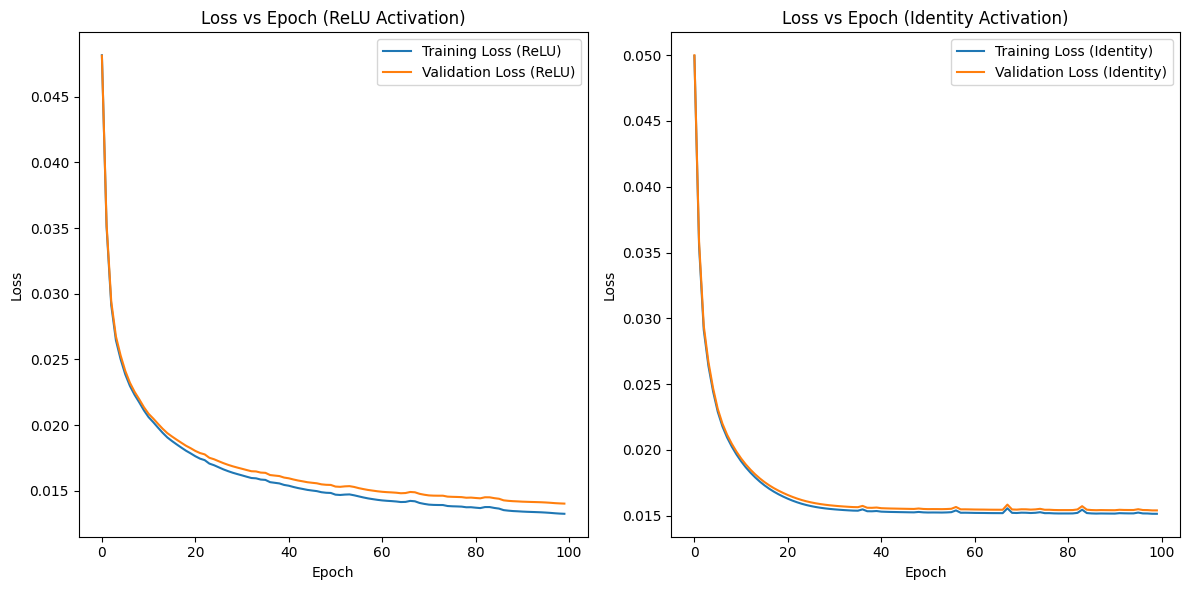

In [14]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(logs['relu']['train_loss'], label='Training Loss (ReLU)')
plt.plot(logs['relu']['val_loss'], label='Validation Loss (ReLU)')
plt.title('Loss vs Epoch (ReLU Activation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(logs['identity']['train_loss'], label='Training Loss (Identity)')
plt.plot(logs['identity']['val_loss'], label='Validation Loss (Identity)')
plt.title('Loss vs Epoch (Identity Activation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Images generated using relu

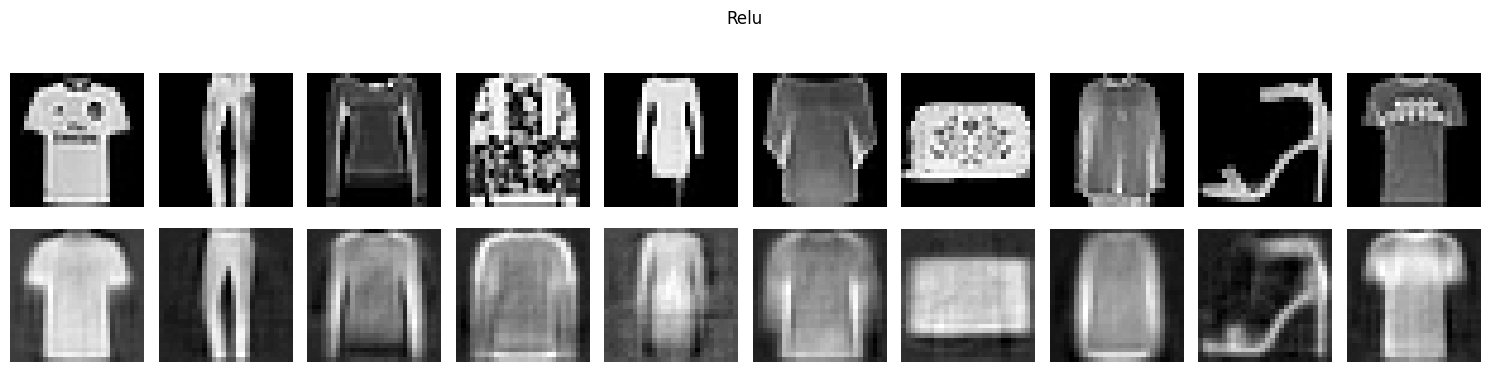

In [15]:
predictions_relu = mlp_r_relu.predict(X_test_scaled.iloc[:10])

plt.figure(figsize=(15, 4))

for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(X_test.iloc[i].values.reshape(28, 28), cmap='gray')
    plt.axis('off')

for i in range(10):
    plt.subplot(2, 10, i + 11) 
    plt.imshow(predictions_relu[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

plt.suptitle("Relu")
plt.tight_layout()
plt.show()


Images generated using identity

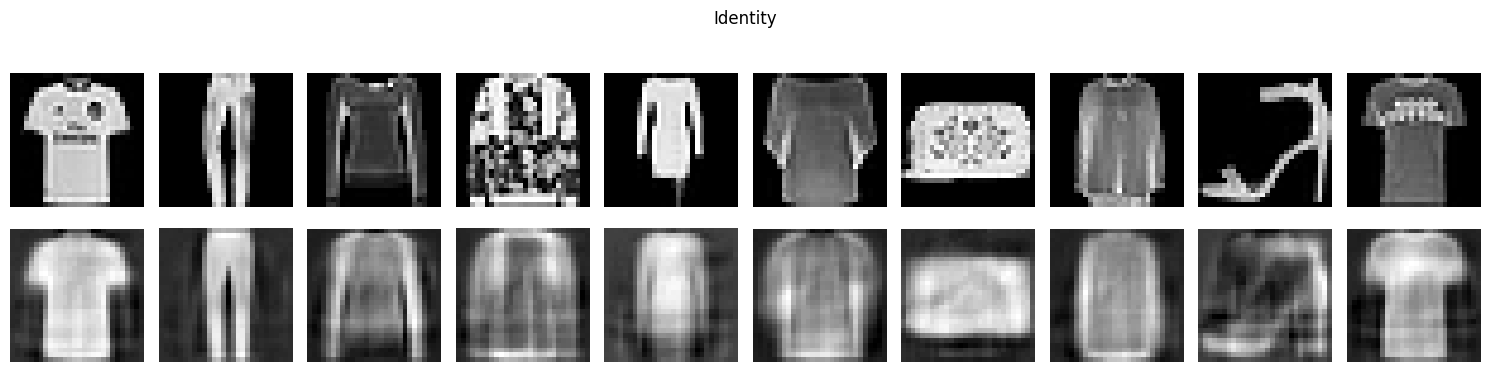

In [78]:
predictions_identity = mlp_r_identity.predict(X_test_scaled.iloc[:10])

plt.figure(figsize=(15, 4))

for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(X_test.iloc[i].values.reshape(28, 28), cmap='gray')
    plt.axis('off')

for i in range(10):
    plt.subplot(2, 10, i + 11)
    plt.imshow(predictions_identity[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

plt.suptitle("Identity")
plt.tight_layout()
plt.show()

# E

Extracting the 32-size vector 

In [23]:
train_features_relu = extract_features(mlp_r_relu, X_train_scaled)
test_features_relu = extract_features(mlp_r_relu, X_test_scaled)

train_features_identity = extract_features(mlp_r_identity, X_train_scaled)
test_features_identity = extract_features(mlp_r_identity, X_test_scaled)

train_features_relu.shape

(8000, 32)

Relu features

In [15]:
small_relu = MLPClassifier(hidden_layer_sizes=[32, 32], max_iter=200, solver='adam', learning_rate_init=2e-5, random_state=42)
small_relu.fit(train_features_relu, y_train)

c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=[32, 32], learning_rate_init=2e-05,
              random_state=42)

In [16]:
y_pred_relu = small_relu.predict(test_features_relu)
accuracy_relu = accuracy_score(y_test, y_pred_relu)

Identity features

In [17]:
small_identity = MLPClassifier(hidden_layer_sizes=[32, 32], max_iter=200, solver='adam', learning_rate_init=2e-5, random_state=42)
small_identity.fit(train_features_identity, y_train)

c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=[32, 32], learning_rate_init=2e-05,
              random_state=42)

In [18]:
y_pred_identity = small_identity.predict(test_features_identity)
accuracy_identity = accuracy_score(y_test, y_pred_identity)

Results

In [19]:
print("Accuracy of classifier trained on ReLU features:", accuracy_relu)
print("Accuracy of classifier trained on Identity features:", accuracy_identity)

Accuracy of classifier trained on ReLU features: 0.712
Accuracy of classifier trained on Identity features: 0.5915
